### MIT Data Analysis and Visualization

#### Importing Libraries

In [5]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import seaborn as sns
import os

In [142]:
data_dir = "./data/rawdata/mit/"

#### ERD Calculator Class

This uses a bandpass filter to calculate the ERD (Event-Related Desynchronization) from EEG data.


In [266]:
class ERDCalculator:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices

    def calculate_erd(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # print(filtered_epoch)

        # Separate pre and post-stimulus data
        pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
        post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]
        
        # pre_stimulus_data = filtered_epoch[:, self.samples_before_marker-int(0.2*self.sampling_freq):self.samples_before_marker]
        # post_stimulus_data = filtered_epoch[:, self.samples_before_marker:self.samples_before_marker + int(0.6*self.sampling_freq)]

        # Calculate power for pre and post stimulus periods
        pre_power = np.nanmean(pre_stimulus_data ** 2, axis=1)
        post_power = np.nanmean(post_stimulus_data ** 2, axis=1)

        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None

def analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculator(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

#### Processing EEG Data

In [169]:
results_df = process_all_subjects(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])

Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...
Extracting parameters from ./data/rawdata/mit/MIT11.vhdr...
Setting channel info structure...
Reading 0 ... 1174599  =      0.000 ...  1174.599 secs...
Extracting parameters from ./data/rawdata/mit/MIT12.vhdr...
Setting channel info structure...
Reading 0 ... 1445479  =      0.000 ...  1445.479 secs...
Extracting parameters from ./data/rawdata/mit/MIT13.vhdr...
Setting channel info structure...
Reading 0 ... 1119699  =      0.000 ...  1119.699 secs...
Extracting parameters from ./data/rawdata/mit/MIT14.vhdr...
Setting channel info structure...
Reading 0 ... 1213539  =      0.000 ...  1213.539 secs...


KeyboardInterrupt: 

#### Plotting ERD Results

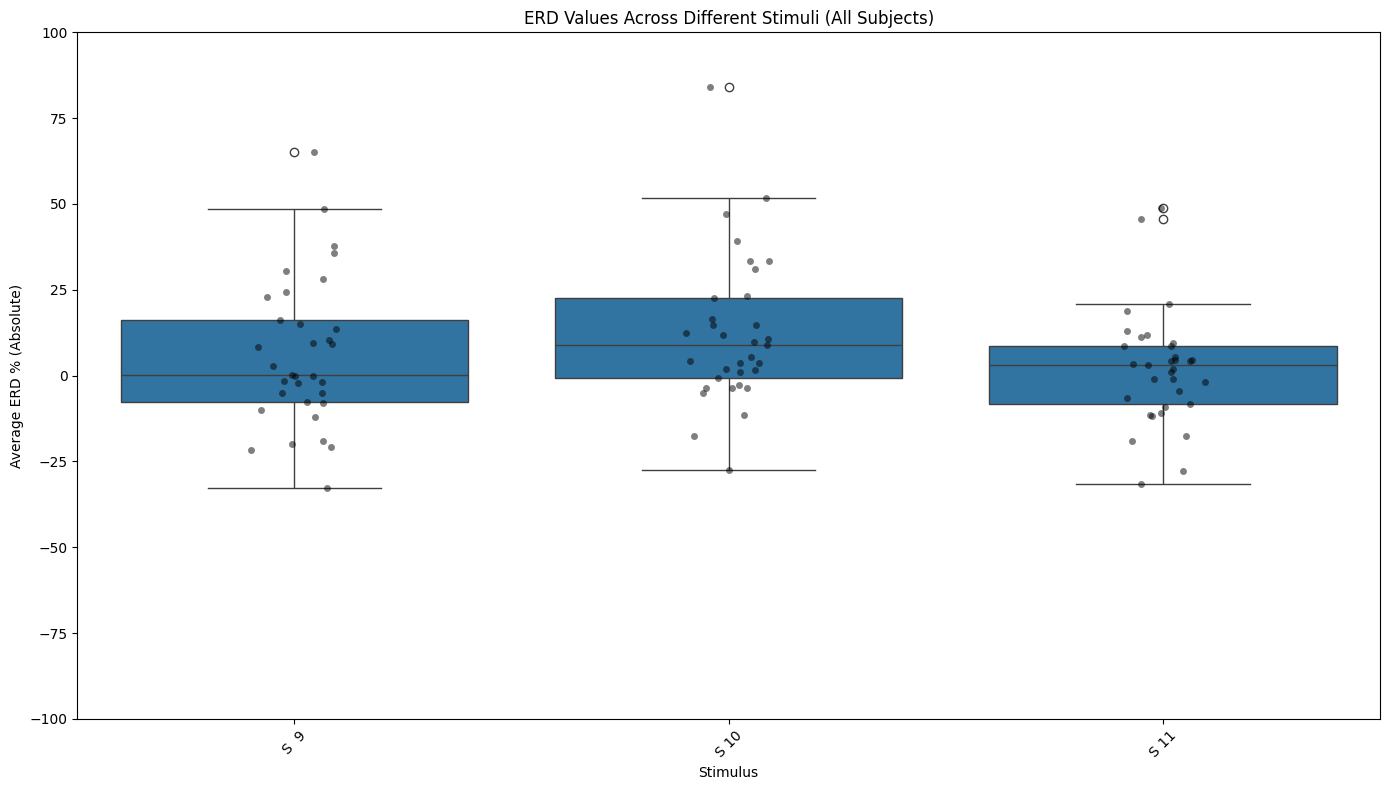

In [ ]:
avg_per_subject_stimulus = results_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### ERD Calculator Class (Welch)

This uses welch's method to calculate the ERD (Event-Related Desynchronization) from EEG data.

In [ ]:
class ERDCalculatorWelch:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.bandpass_low = bandpass_low
        self.bandpass_high = bandpass_high
        # self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices

    def calculate_erd(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        # filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # print(filtered_epoch)

        # Separate pre and post-stimulus data
        pre_stimulus_data = epoch_data[:, :self.samples_before_marker]
        post_stimulus_data = epoch_data[:, self.samples_before_marker:]
        
        f_pre, Pxx_pre = welch(pre_stimulus_data, fs=self.sampling_freq, axis=1)
        f_post, Pxx_post = welch(post_stimulus_data, fs=self.sampling_freq,  axis=1)

        # Ensure the frequency bands are within the range of interest
        band_low_index = np.searchsorted(f_pre, self.bandpass_low)
        band_high_index = np.searchsorted(f_pre, self.bandpass_high)
        if band_low_index >= band_high_index:
            print("Invalid frequency band indices for ERD calculation.")
            return None
        # Extract the power in the alpha band (8-30 Hz)
        pre_power = np.nanmean(Pxx_pre[:, band_low_index:band_high_index], axis=1)
        post_power = np.nanmean(Pxx_post[:, band_low_index:band_high_index], axis=1)


        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None

In [ ]:
def analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculatorWelch(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects_welch(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

#### Processing EEG Data

In [ ]:
results_welch_df = process_all_subjects_welch(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])


Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...
Extracting parameters from ./data/rawdata/mit/MIT11.vhdr...
Setting channel info structure...
Reading 0 ... 1174599  =      0.000 ...  1174.599 secs...
Extracting parameters from ./data/rawdata/mit/MIT12.vhdr...
Setting channel info structure...
Reading 0 ... 1445479  =      0.000 ...  1445.479 secs...
Extracting parameters from ./data/rawdata/mit/MIT13.vhdr...
Setting channel info structure...
Reading 0 ... 1119699  =      0.000 ...  1119.699 secs...
Extracting parameters from ./data/rawdata/mit/MIT14.vhdr...
Setting channel info structure...
Reading 0 ... 1213539  =      0.000 ...  1213.539 secs...
Extracting parameters from ./data/rawdata/mit/MIT15.vhdr...
Setting channel info structur

#### Plotting ERD Results

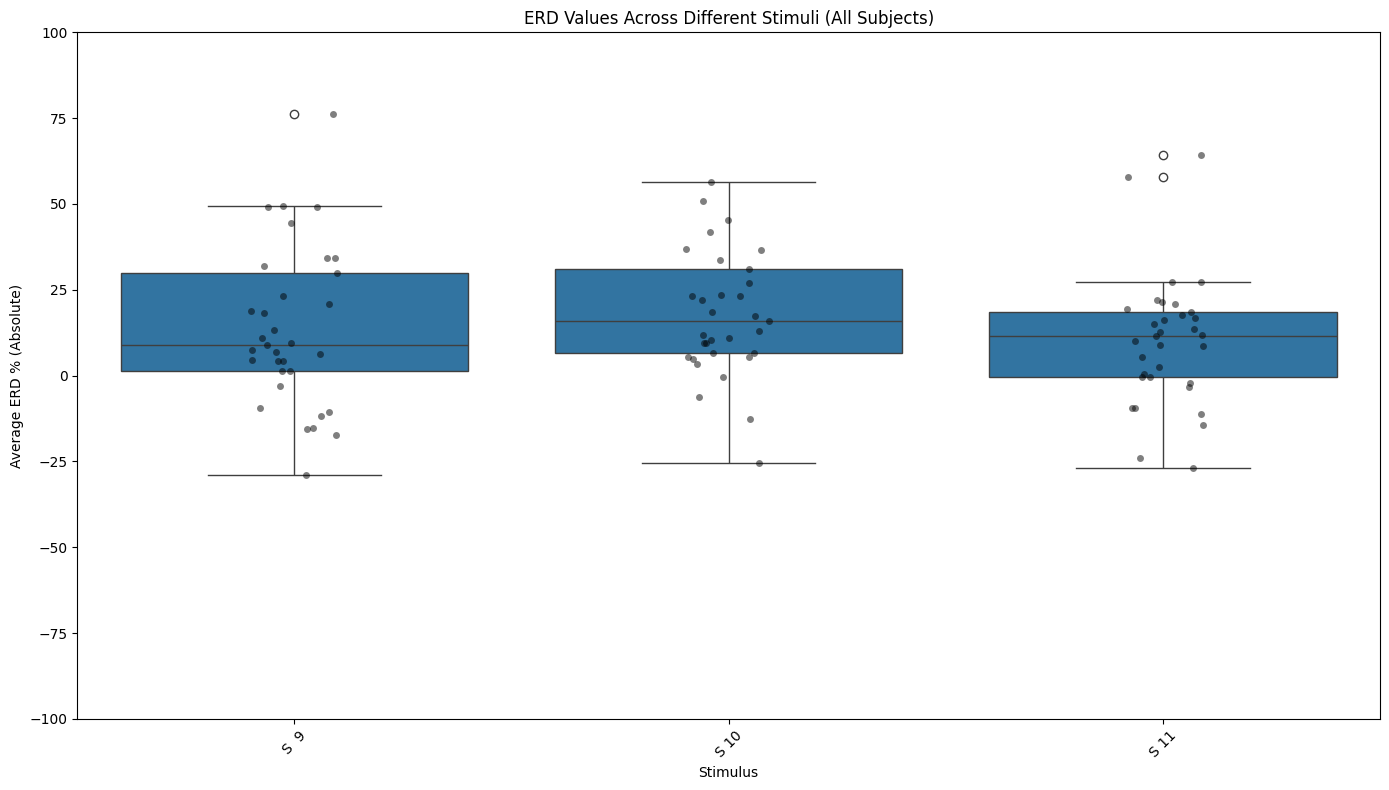

In [ ]:
avg_per_subject_stimulus = results_welch_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Nature Data Analysis and Visualization

#### Importing Libraries

In [6]:
import scipy.io as sio

#### Restructuring Data

In [7]:
data_dir = "./data/rawdata/nature/"

In [8]:
raw_data = sio.loadmat(os.path.join(data_dir, '5F-SubjectE.mat'))

In [9]:
sampling_frequency = raw_data['o'][0][0][2][0][0]
num_samples = raw_data['o'][0][0][3][0][0]
markers = raw_data['o'][0][0][4]
data = raw_data['o'][0][0][5]
channel_names = [raw_data['o'][0][0][6][i][0][0] for i in range(len(raw_data['o'][0][0][6]))]

In [10]:
channel_names

[np.str_('Fp1'),
 np.str_('Fp2'),
 np.str_('F3'),
 np.str_('F4'),
 np.str_('C3'),
 np.str_('C4'),
 np.str_('P3'),
 np.str_('P4'),
 np.str_('O1'),
 np.str_('O2'),
 np.str_('A1'),
 np.str_('A2'),
 np.str_('F7'),
 np.str_('F8'),
 np.str_('T3'),
 np.str_('T4'),
 np.str_('T5'),
 np.str_('T6'),
 np.str_('Fz'),
 np.str_('Cz'),
 np.str_('Pz'),
 np.str_('X5')]

In [11]:
data_df = pd.DataFrame(data, columns=channel_names)
markers_df = pd.DataFrame(markers, columns=[ 'description']).reset_index().rename(columns={'index': 'onset'})


In [12]:
is_new_marker_start = (markers_df['description'] != 0) & \
                      (markers_df['description'].shift(1) != markers_df['description'])


In [13]:
is_new_marker_start[is_new_marker_start]

151133     True
156174     True
160212     True
163255     True
165297     True
           ... 
3563949    True
3567497    True
3570469    True
3573889    True
3577525    True
Name: description, Length: 952, dtype: bool

#### Configurations

In [ ]:
class ERDCalculator:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices

    def calculate_erd(self, data, markers):
        """
        Calculates the ERD for a given epoch.

        Args:
            data (np.array): The EEG data.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        # if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
        #     print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
        #     return None
        
        # Apply the bandpass filter
        filtered_epoch = filtfilt(self.b, self.a, data, axis=1)
        
        # print(filtered_epoch)

        # Separate pre and post-stimulus data
        pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
        post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]
        
        # pre_stimulus_data = filtered_epoch[:, self.samples_before_marker-int(0.2*self.sampling_freq):self.samples_before_marker]
        # post_stimulus_data = filtered_epoch[:, self.samples_before_marker:self.samples_before_marker + int(0.6*self.sampling_freq)]

        # Calculate power for pre and post stimulus periods
        pre_power = np.nanmean(pre_stimulus_data ** 2, axis=1)
        post_power = np.nanmean(post_stimulus_data ** 2, axis=1)

        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None

In [261]:
focus_channel_names = ["Fz"]
focus_stimuli=[1, 2, 3, 4, 5]
epoch_pre_stimulus_seconds = 1.0
epoch_post_stimulus_seconds = 1.0
bandpass_low = 8.0
bandpass_high = 13.0 # Alpha band
focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

erd_calculator = ERDCalculatorWelch(
    sampling_frequency,
    epoch_pre_stimulus_seconds,
    epoch_post_stimulus_seconds,
    bandpass_low,
    bandpass_high,
    channel_names,
    focus_channels_indices
)

#### ERD Analysis

In [ ]:
results = []
    

for index, row in markers_df[is_new_marker_start].copy().iterrows():
    onset_sample = row['onset']
    stimulus_description = row['description']
    
    # Filter for focus stimuli if specified
    if focus_stimuli and stimulus_description not in focus_stimuli:
        continue

    # Define epoch boundaries
    start_sample = onset_sample - erd_calculator.samples_before_marker
    end_sample = onset_sample + erd_calculator.samples_after_marker

    # Ensure the epoch is within the data bounds
    if start_sample >= 0 and end_sample < len(data_df):
        # Extract epoch data for all channels
        
        epoch_data = data_df.iloc[start_sample:end_sample][channel_names].values.T
        
        # Calculate ERD
        erd_value = erd_calculator.calculate_erd(epoch_data)

        if erd_value is not None:
            results.append({'stimulus': stimulus_description, 'erd_value': erd_value})



In [263]:
results_df = pd.DataFrame(results)
results_df.head()

,stimulus,erd_value
0,1,195.532175
1,4,213.992902
2,2,-45.491082
3,5,45.707421
4,1,59.950169


#### Plotting ERD Results

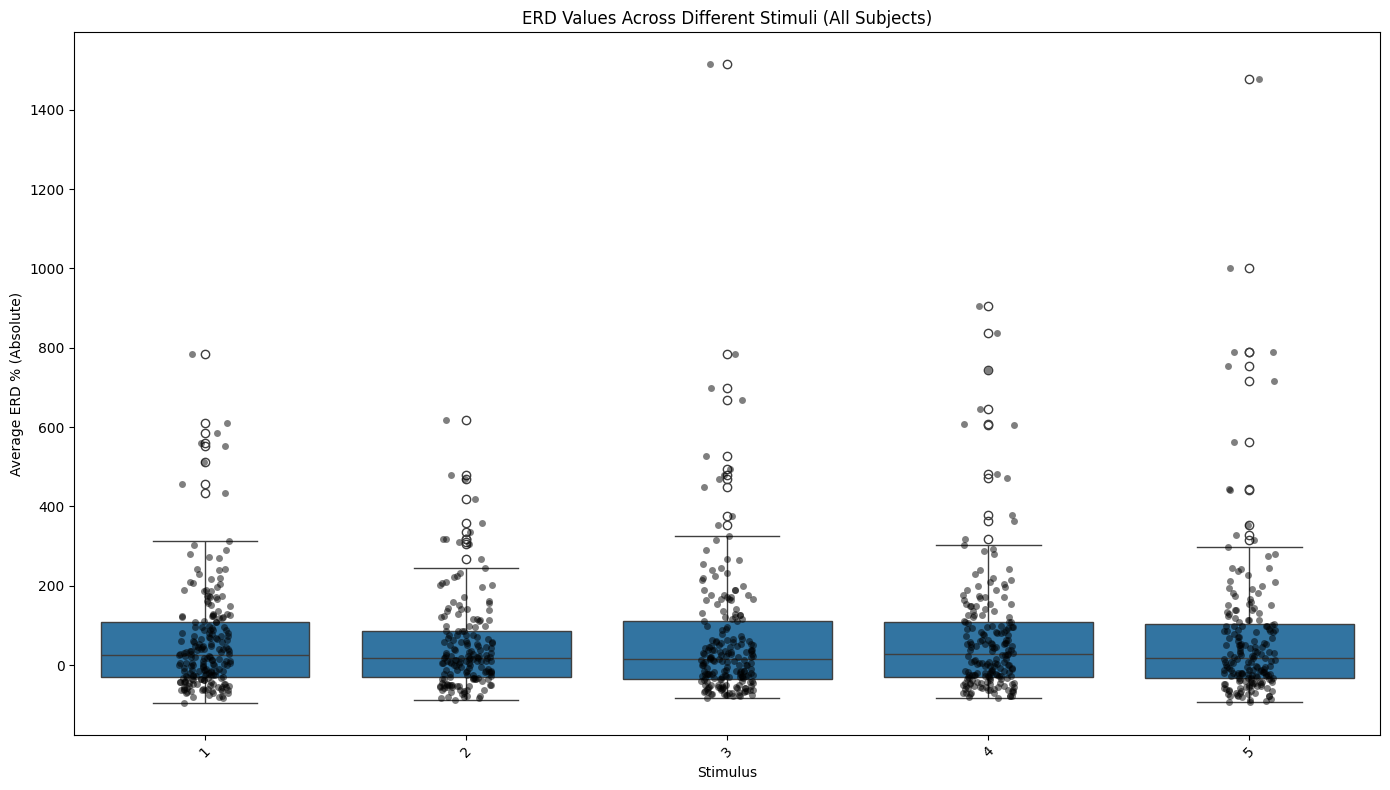

In [265]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=results_df)
sns.stripplot(x='stimulus', y='erd_value', data=results_df, jitter=True, color='black', alpha=0.5, dodge=True)
# plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### New

In [58]:
class ERDCalculatorNew:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices, focus_stimuli=None):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.b, self.a = butter(5, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices
        self.focus_stimuli = focus_stimuli

    def calculate_erd(self, data_df, markers_df, subject_id=None):
            """
            Calculates ERD/ERS for each stimulus type.
            
            Args:
                data_df (pd.DataFrame): DataFrame with channels as columns and samples as rows.
                markers_df (pd.DataFrame): DataFrame with 'onset' (in samples) and 'description' columns.
            
            Returns:
                dict: A dictionary where keys are stimulus descriptions and values are the
                    calculated mean ERD/ERS percentages for the focus channels.
                    Returns an empty dictionary if no valid epochs are found.
            """
            # --- 1. GATHER AND GROUP EPOCHS BY STIMULUS ---


            epochs_by_stimulus = {}
            for row in markers_df.itertuples():
                onset_sample = row.onset
                stimulus_description = row.description
                
                
                # Filter for focus stimuli if specified
                if self.focus_stimuli and stimulus_description not in self.focus_stimuli:
                    continue
                print(f"Processing stimulus: {stimulus_description} at onset sample: {onset_sample}")

                # Define epoch boundaries
                start_sample = onset_sample - self.samples_before_marker
                end_sample = onset_sample + self.samples_after_marker

                # Ensure the epoch is within the data bounds
                if start_sample >= 0 and end_sample < len(data_df):
                    # Extract epoch data for all channels
                    epoch = data_df.iloc[start_sample:end_sample].values.T # (n_channels, n_samples)
                    
                    # Apply bandpass filter
                    epoch_filtered = filtfilt(self.b, self.a, epoch, axis=1)
                    
                    # Square to get instantaneous power
                    epoch_power = epoch_filtered**2
                    
                    # Group epochs by their stimulus description
                    if stimulus_description not in epochs_by_stimulus:
                        epochs_by_stimulus[stimulus_description] = []
                    epochs_by_stimulus[stimulus_description].append(epoch_power)
            
            # --- 2. CALCULATE ERD FOR EACH STIMULUS SEPARATELY ---
            erd_results = {}
            for stimulus, epochs_list in epochs_by_stimulus.items():
                if not epochs_list:
                    continue # Skip if for some reason the list is empty

                # Stack all epochs for the current stimulus into a 3D numpy array
                # Shape: (n_channels, n_timepoints, n_trials)
                epochs_stack = np.stack(epochs_list, axis=2)
                
                # Average power across all trials for this stimulus
                mean_power_across_trials = np.nanmean(epochs_stack, axis=2) # (n_channels, n_timepoints)
                
                # Define baseline (pre-marker) and activation (post-marker) periods
                baseline_power = mean_power_across_trials[:, :self.samples_before_marker]
                activation_power = mean_power_across_trials[:, self.samples_before_marker:]
                
                # Average the power across time for baseline and activation periods
                mean_baseline = np.nanmean(baseline_power, axis=1)    # (n_channels,)
                mean_activation = np.nanmean(activation_power, axis=1) # (n_channels,)
                
                # print((mean_baseline.shape), (mean_activation.shape), len(self.channel_names))
                # print(f"Mean Baseline: {mean_baseline}, Mean Activation: {mean_activation}")
                
                
                # Calculate ERD/ERS percentage, avoiding division by zero
                # ERD will be negative, ERS will be positive
                erd_percent = np.full(len(self.channel_names), np.nan)
                non_zero_indices = mean_baseline != 0
                
                erd_percent[non_zero_indices] = ((mean_activation[non_zero_indices] - mean_baseline[non_zero_indices]) / mean_baseline[non_zero_indices]) * 100
                
                # Extract ERD for focus channels
                erd_percent_focus = erd_percent[self.focus_channels_indices]
                
                # Calculate the mean ERD/ERS for the focus channels and store it
                if np.any(~np.isnan(erd_percent_focus)):
                    erd_results[stimulus] = np.nanmean(erd_percent_focus)
                else:
                    erd_results[stimulus] = None # Or np.nan
                
                if subject_id is not None:
                    erd_results['subject_id'] = subject_id

            return erd_results

In [59]:
focus_channel_names = ["C3"]
focus_stimuli=[1, 2, 3, 4, 5]
epoch_pre_stimulus_seconds = 1.0
epoch_post_stimulus_seconds = 1.0
bandpass_low = 8.0
bandpass_high = 30.0 # Alpha band
focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

erd_calculator = ERDCalculatorNew(
    sampling_frequency,
    epoch_pre_stimulus_seconds,
    epoch_post_stimulus_seconds,
    bandpass_low,
    bandpass_high,
    channel_names,
    focus_channels_indices,
    focus_stimuli=focus_stimuli
)

In [38]:
erd_results = erd_calculator.calculate_erd(data_df, markers_df[is_new_marker_start].copy())

Processing stimulus: 1 at onset sample: 168745
Processing stimulus: 4 at onset sample: 172605
Processing stimulus: 2 at onset sample: 175515
Processing stimulus: 5 at onset sample: 178871
Processing stimulus: 1 at onset sample: 182635
Processing stimulus: 5 at onset sample: 186422
Processing stimulus: 5 at onset sample: 189712
Processing stimulus: 3 at onset sample: 192646
Processing stimulus: 4 at onset sample: 196361
Processing stimulus: 4 at onset sample: 200127
Processing stimulus: 5 at onset sample: 202960
Processing stimulus: 4 at onset sample: 206707
Processing stimulus: 4 at onset sample: 210274
Processing stimulus: 4 at onset sample: 213460
Processing stimulus: 4 at onset sample: 216436
Processing stimulus: 2 at onset sample: 219262
Processing stimulus: 1 at onset sample: 222116
Processing stimulus: 4 at onset sample: 225736
Processing stimulus: 5 at onset sample: 228858
Processing stimulus: 3 at onset sample: 231696
Processing stimulus: 4 at onset sample: 234877
Processing st

In [30]:
erd_results

{1: np.float64(-3.241572744389485),
 4: np.float64(-6.238504233190965),
 2: np.float64(-11.656413604389181),
 5: np.float64(-8.61317286494864),
 3: np.float64(-16.812655272639674)}

In [60]:
data_dir = "./data/rawdata/mit/"


In [63]:
def analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations
    
    df.drop(columns=['time'], inplace=True)  # Remove time column if it exists
    

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main', 'onset'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)
    annotations_df.rename(columns={'absolute_onset': 'onset'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculatorNew(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices,
        focus_stimuli=focus_stimuli
    )
    
    return erd_calculator.calculate_erd(df, annotations_df[annotations_df['description'].isin(focus_stimuli)].copy(), subject_id=subject_id)

    # --- 4. ERD Calculation Loop ---
    
        
def process_all_subjects(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.DataFrame(results)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

In [64]:
result = process_all_subjects(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])

Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Processing stimulus: S  9 at onset sample: 17393
Processing stimulus: S  9 at onset sample: 22585
Processing stimulus: S  9 at onset sample: 32351
Processing stimulus: S  9 at onset sample: 37617
Processing stimulus: S  9 at onset sample: 42690
Processing stimulus: S 10 at onset sample: 60987
Processing stimulus: S 10 at onset sample: 66212
Processing stimulus: S 10 at onset sample: 75274
Processing stimulus: S 10 at onset sample: 80637
Processing stimulus: S 10 at onset sample: 85668
Processing stimulus: S 11 at onset sample: 104515
Processing stimulus: S 11 at onset sample: 109822
Processing stimulus: S 11 at onset sample: 114952
Processing stimulus: S 11 at onset sample: 120006
Processing stimulus: S 11 at onset sample: 125032
Processing stimulus: S 11 at onset sample: 143013
Processing stimulus: S 11 at onset sample: 148287
Processin

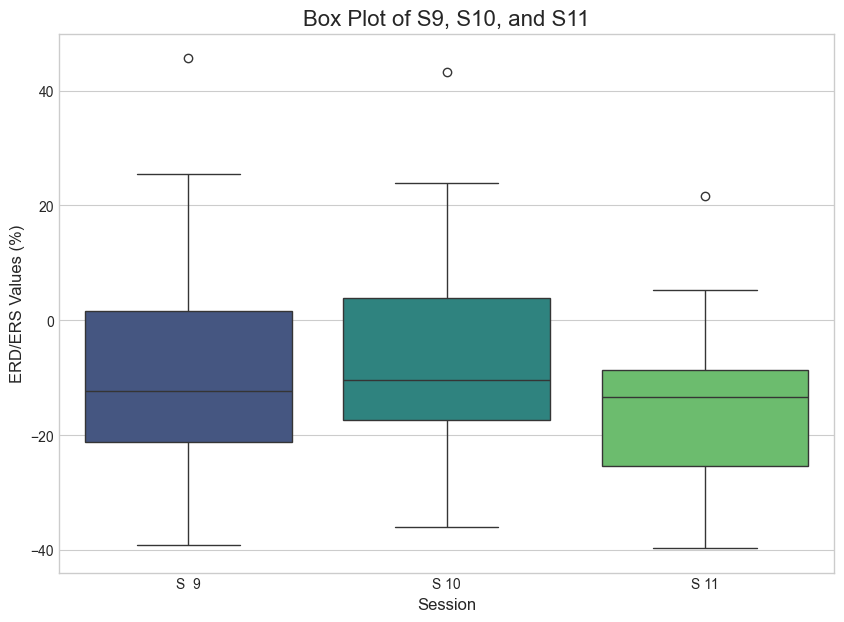

In [67]:
df_to_plot = result[['S  9', 'S 10', 'S 11']]

# 2. Create the box plot using seaborn
plt.style.use('seaborn-v0_8-whitegrid') # Using a nice style for the plot
plt.figure(figsize=(10, 7)) # Set the figure size

sns.boxplot(data=df_to_plot, palette='viridis')

# 3. Add titles and labels for clarity
plt.title('Box Plot of S9, S10, and S11', fontsize=16)
plt.ylabel('ERD/ERS Values (%)', fontsize=12)
plt.xlabel('Session', fontsize=12)

# 4. Show the plot
plt.show()